## Capítulo 06 - Explorando os Dados

Antes de criar um modelo, faremos algumas análises de dados exploratórias. Isso nos dará uma noção dos dados, mas também é uma maneira de conhecer as unidades de negócio que controlam esses dados e discutir os problemas com elas.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.experimental import (
    enable_iterative_imputer,
)
from sklearn import (
    ensemble,
    impute,
    model_selection,    
    preprocessing,
    tree,
)

In [2]:
# Caminho em Pasta
path = "datasets/titanic/titanic3.xls"
df = pd.read_excel(path)
orig_df = df

In [3]:
def tweak_titanic(df):
    df = df.drop(
        columns=[
            "name",
            "ticket",
            "home.dest",
            "boat",
            "body",
            "cabin",
        ]
    ).pipe(pd.get_dummies, drop_first=True)
    return df

def get_train_test_X_y(
    df, y_col, size=0.3, std_cols=None
):
    y = df[y_col]
    X = df.drop(columns=y_col)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=size, random_state=42
    )
    cols = X.columns
    num_cols = [
        "pclass",
        "age",
        "sibsp",
        "parch",
        "fare",
    ]
    fi = impute.IterativeImputer()
    fitted = fi.fit_transform(X_train[num_cols])
    X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(num_cols)})
    test_fit = fi.transform(X_test[num_cols])
    X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(num_cols)})
    if std_cols:
        std = preprocessing.StandardScaler()
        fitted = std.fit_transform(X_train[std_cols])
        X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(std_cols)})
        test_fit = std.transform(X_test[std_cols])
        X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(std_cols)})

    return X_train, X_test, y_train, y_test

ti_df = tweak_titanic(orig_df)
std_cols = "pclass,age,sibsp,fare".split(",")
X_train, X_test, y_train, y_test = get_train_test_X_y(
    ti_df, "survived", std_cols=std_cols
)

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

### Tamanhos dos dados 

Usaremos o conjunto de dados do Titanic nesse caso. A propriedade .shape do pandas devolve uma tupla com o número de linhas e colunas.

In [4]:
df.dtypes

pclass         int64
survived       int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object

In [5]:
X.shape

(1309, 8)

Esse conjunto de dados contém 1309 linhas e 08 colunas

### Estatísticas resumidas

Podemos usar o pandas para obter estatísticas resumidas de nossos dados. O método .describe nos dará também o número de valores diferentes de NaN.

In [6]:
# Vamos ver o resultado para a primeira e última colunas:
X.describe().iloc[:,[0, -1]]

,pclass,embarked_S
count,1309.000000,1309.000000
mean,-0.012831,0.698243
std,0.995822,0.459196
min,-1.551881,0.000000
25%,-0.363317,0.000000
50%,0.825248,1.000000
75%,0.825248,1.000000
max,0.825248,1.000000


A linha de contadores (count) nos informa que as duas colunas estão preenchidas. Não há valores ausentes. Também temos a média, o desvio-padrão, os valores mínimo e máximo e dos quartis.

In [7]:
# Nesse exemplo, extraímos a segunda e a quinta linhas, e as últimas três colunas
X.iloc[[1, 4], -3:]

,sex_male,embarked_Q,embarked_S
677,1,0,1
864,0,0,1


In [8]:
# Com o atributo .loc, pode-se extrair as linhas e colunas com base no nome (em vez de posição):
X.loc[[677, 864], "sex_male":]

,sex_male,embarked_Q,embarked_S
677,1,0,1
864,0,0,1


### Histogramas

Um histograma é uma ótima ferramenta para visualizar dados numéricos. Podemos ver quantos modos há, bem como observar a distribuição. A biblioteca pandas tem um método .plot para exibir histogramas.

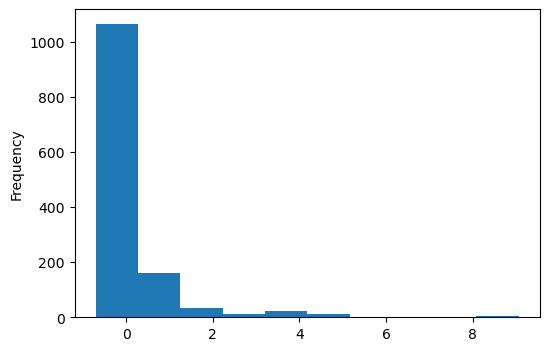

In [9]:
fig, ax = plt.subplots(figsize=(6, 4))
X.fare.plot(kind="hist", ax=ax)
fig.savefig("images/mlpr_0601.png", dpi=300)

Ao usar a biblioteca seaborn, podemos gerar um histograma de valores contínuos em relação ao alvo.

/home/luciano/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/luciano/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


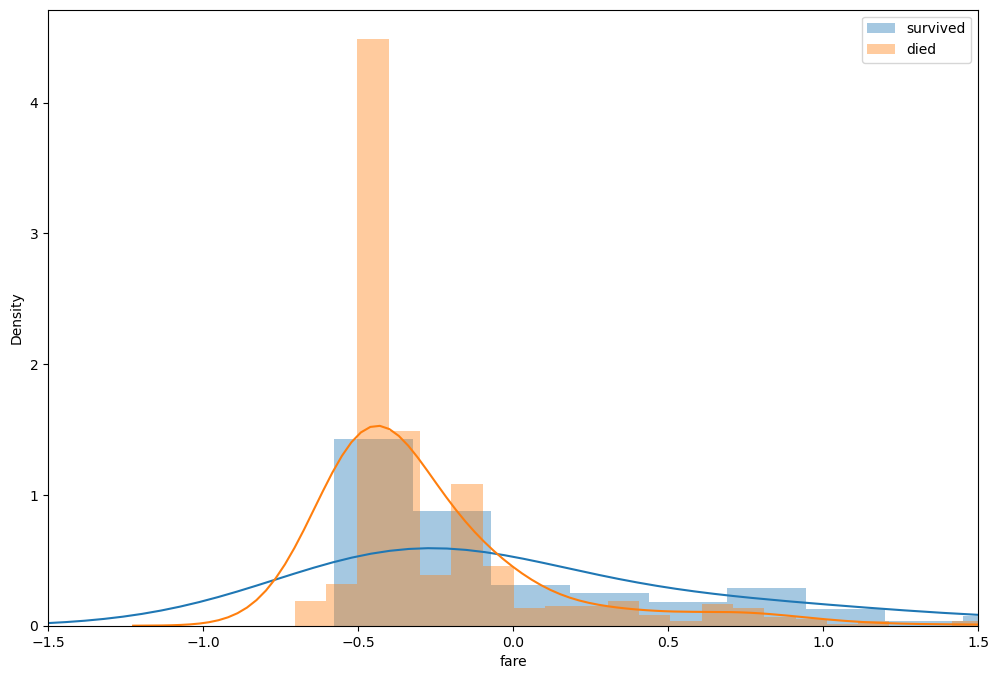

In [10]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(12, 8))
mask = y_train == 1
ax = sns.distplot(X_train[mask].fare, label='survived')
ax = sns.distplot(X_train[~mask].fare, label='died')
ax.set_xlim(-1.5, 1.5)
ax.legend()
fig.savefig('images/mlpr_0602.png', dpi=300, bbox_inches='tight')

### Gráfico de dispersão

Um gráfico de dispersão (scatter plot) mostra o relacionamento entre duas colunas numéricas. Novamente isso é fácil de fazer com o pandas.
Ajuste o parâmetro alpha caso tenha dados que se sobreponham.

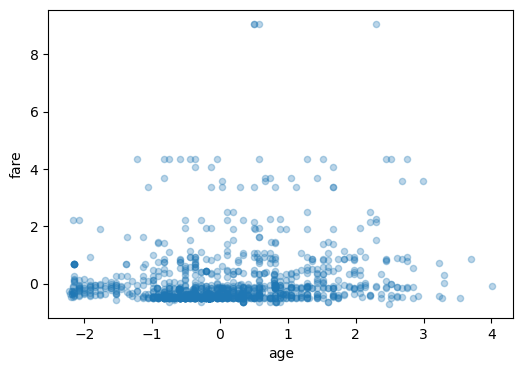

In [11]:
fig, ax = plt.subplots(figsize=(6, 4))
X.plot.scatter(
    x="age", y="fare", ax=ax, alpha=0.3)
fig.savefig("images/mlpr_0603.png", dpi=300)

Não parece haver muita correlação entre esses dois atributos. Podemos usar a correlação de Pearson entre duas colunas (pandas) aplicando o método .corr para quantificá-las.

In [12]:
X.age.corr(df.fare)

0.17888614728992777

### Gráfico de Conjunto 

O Yellowbrick tem um gráfico de dispersão mais sofisticado que inclui histogramas nas bordas e uma linha de regressão, chamada gráfico conjunto (join plot)

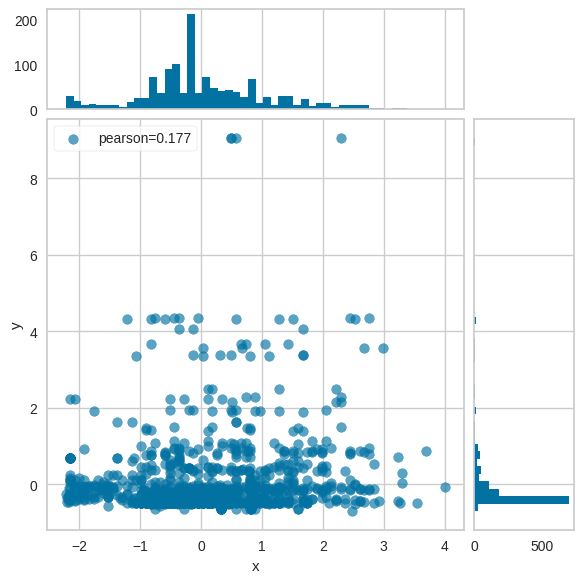

In [13]:
from yellowbrick.features import (
    JointPlotVisualizer,
)

fig,ax = plt.subplots(figsize=(6,6))
jpv = JointPlotVisualizer(
    feature="age", target="fare"
)
jpv.fit(X["age"], X["fare"])
jpv.poof()
fig.savefig("images/mlpr_0604.png", dpi=300)

Também podemos usar a biblioteca seaborn (https://seaborn.pydata.org) para criar um gráfico conjunto

/home/luciano/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


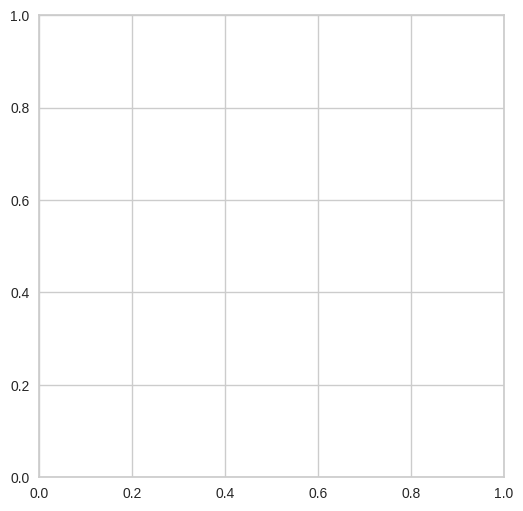

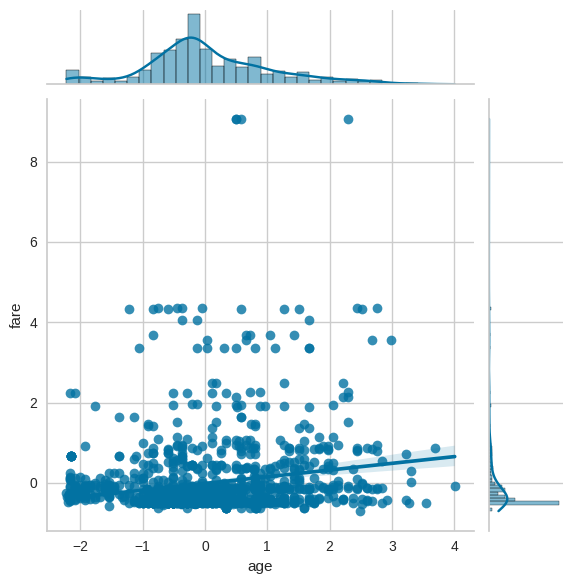

In [14]:
from seaborn import jointplot
fig, ax = plt.subplots(figsize=(6, 6))
df_new = X.copy()
df_new["target"] = y
p = jointplot(
    "age", "fare", data=df_new, kind="reg"
)
p.savefig("images/mlpr_0605.png", dpi=300)

### Matriz de pares

A biblioteca seaborn é capaz de criar uma matriz de pares(pair grid). O gráfico abaixo contém uma matriz de colunas e estimativas de densidade kernel. Para colorir de acordo com uma coluna de um DataFrame, utilize o parâmetro hue. Ao colorir de acordo com o alvo, podemos ver se os atributos lhe causam efeitos diferentes:

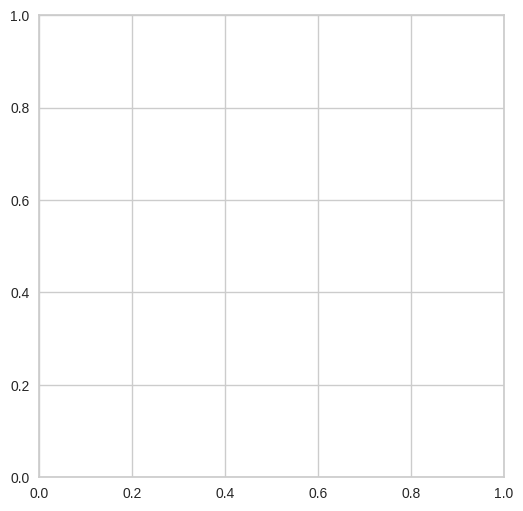

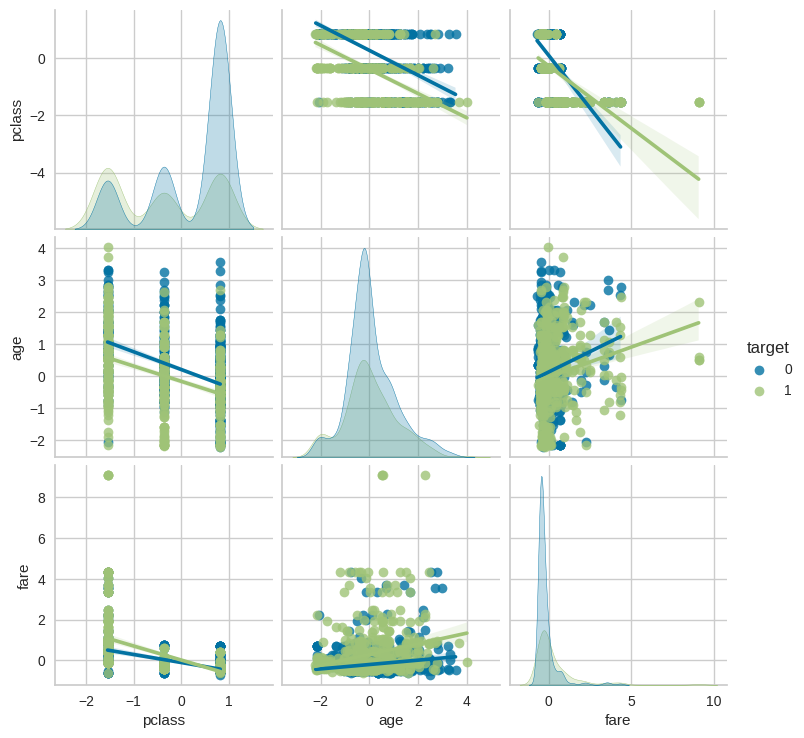

In [15]:
from seaborn import pairplot
fig, ax = plt.subplots(figsize=(6, 6))
new_df = X.copy()
new_df["target"] = y
vars = ["pclass", "age", "fare"]
p = pairplot(
    new_df, vars=vars, hue="target", kind="reg"
)
p.savefig("images/mlpr_0606.png", dpi=300)


### Gráfico de caixas e gráfico violino

O seaborn tem diversos gráficos para visualizar as distribuições. Será mostrado exemplos de um gráfico de caixa (box plot) e de um gráfico violino (violin plot). Esses gráficos podem exibir um atributo em relação a um alvo:

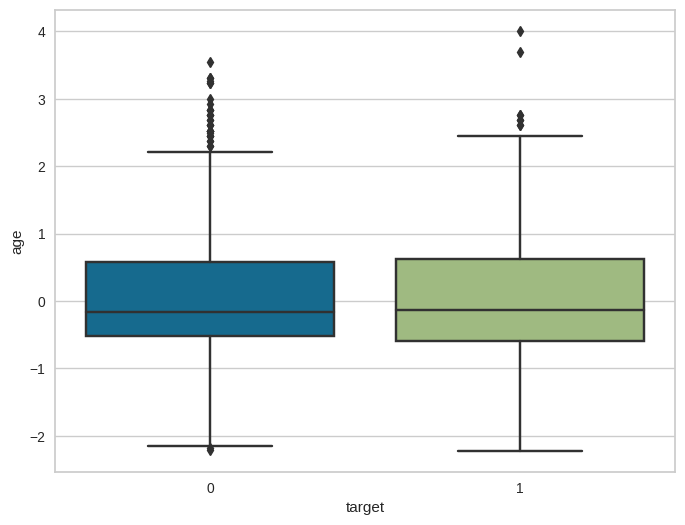

In [16]:
from seaborn import boxplot
fig, ax = plt.subplots(figsize=(8, 6))
new_df = X.copy()
new_df["target"] = y
boxplot(x="target", y="age", data=new_df)
fig.savefig("images/mlpr_0607.png", dpi=300)

Gráficos de violino podem ajudar na visualização de distribuições:

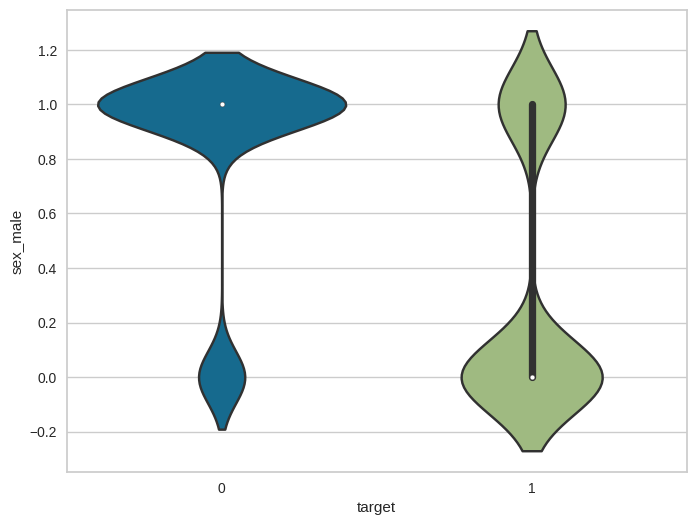

In [17]:
from seaborn import violinplot
fig, ax = plt.subplots(figsize=(8,6))
new_df = X.copy()
new_df["target"] = y
violinplot(
    x="target", y="sex_male", data=new_df
)
fig.savefig("images/mlpr_0608.png", dpi=300)

### Comparando dois valores ordinais

Neste exemplo, temos um código pandas que compara duas categorias ordinais. Nesta simulação com a separação da idade em dez quantis e pclass em três grupos. O gráfico foi normalizado, portanto ele preenche toda a área vertical. Isso facilita ver que, no quantil 40%, a maioria das passagens era de terceira classe

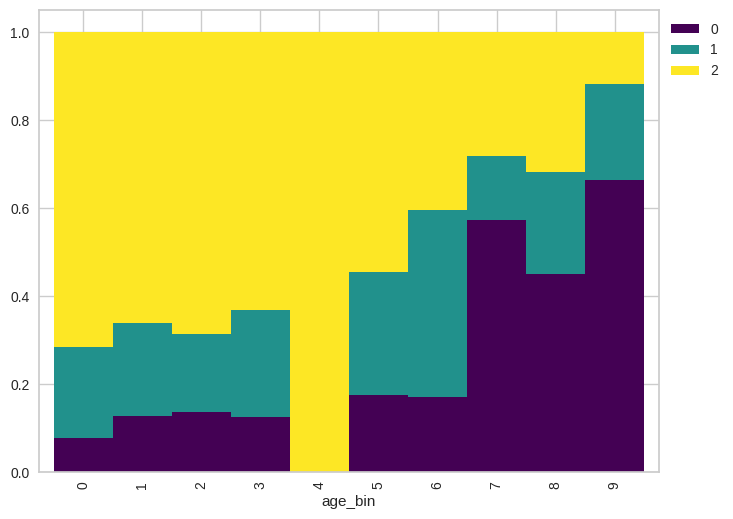

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))
(
    X.assign(
        age_bin = pd.qcut(
            X.age, q=10,labels=False
        ),
        class_bin = pd.cut(
            X.pclass, bins=3, labels=False
        ),
    )
    .groupby(["age_bin", "class_bin"])
    .size()
    .unstack()
    .pipe(lambda df: df.div(df.sum(1), axis=0))
    .plot.bar(
        stacked=True,
        width=1,
        ax=ax,
        cmap="viridis",
    )
    .legend(bbox_to_anchor=(1, 1))
)
fig.savefig(
    "images/mlpr_0609.png",
    dpi=300,
    bbox_inches="tight",
)

NOTA:
    
    As linhas:
        .groupby(["age_bin", "class_bin"])
        .size()
        .unstack()
    
    podem ser substiuídas por:
        .pipe(lambda, df: pd.crosstab(
            df.age_bin, df.class_bin)
        )
        
No pandas, em geral há mais de uma maneira de fazer uma tarefa, e algumas funções auxiliares que fazem parte de outras funcionalidades estão disponíveis, por exemplo, pd.crosstab

### Correlação

O Yellowbrick é capaz de fazer comparações aos pares entre os atributos. O gráfico a seguir mostra uma correlação de Pearson (o parâmetro algorithm também aceita 'spearman' e 'covariance'):

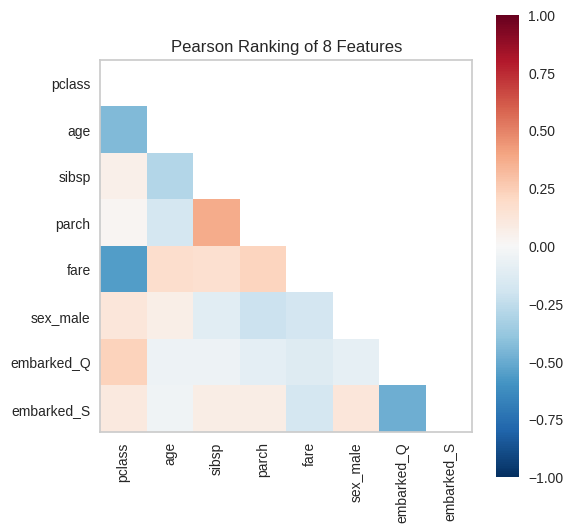

In [19]:
from yellowbrick.features import Rank2D
fig, ax = plt.subplots(figsize=(6, 6))
pcv = Rank2D(
    features=X.columns, algorithm="pearson"
)
pcv.fit(X, y)
pcv.transform(X)
pcv.poof()
fig.savefig(
    "images/mlpr_0610.png",
    dpi=300,
    bbox_inches="tight",
)

Um gráfico semelhante - um heat map (mapa de calor) - está disponível na biblioteca seaborn. Temos de passar um DataFrame de correlações como dado. 
Infelizmente, a barra de cores não se estende entre -1 e 1, a menos que os valores na matriz, o façam, ou que acrescentemos os parâmetros "vmin" e "vmax":

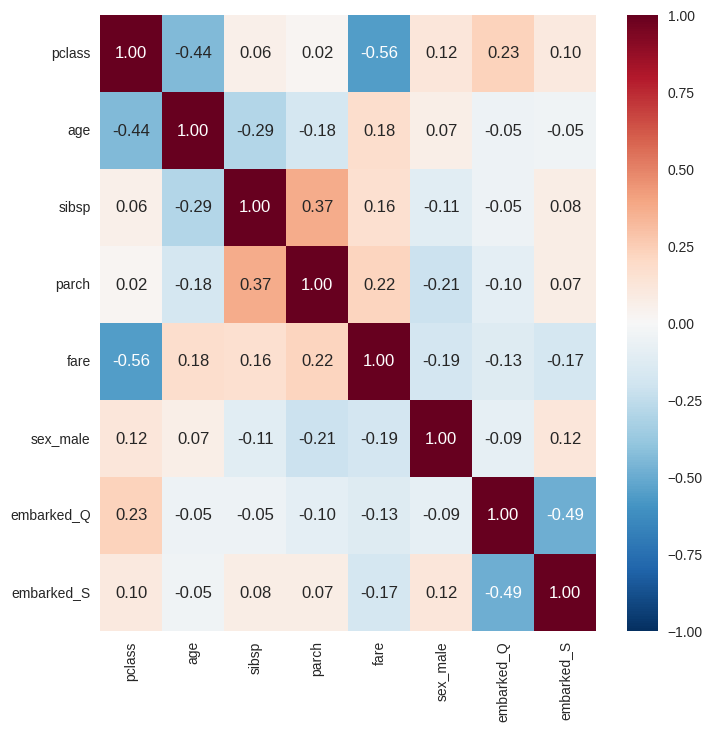

In [20]:
from seaborn import heatmap
fig, ax = plt.subplots(figsize=(8, 8))
ax = heatmap(
    X.corr(),
    fmt = ".2f",
    annot=True,
    ax=ax,
    cmap="RdBu_r",
    vmin=-1,
    vmax=1
)
fig.savefig(
    "images/mlpr_0611.png",
    dpi=300,
    bbox_inches="tight",
)

A biblioteca pandas também pode apresentar uma correlação entre colunas do DataFrame. Será exibido apenas as duas primeiras colunas do resultado. O método default é "pearson", mas é possível definir também o parâmetro method com "kendall", "spearman" ou com um callable personalizado que devolva um número de ponto flutuante, dada as duas colunas:

In [21]:
X.corr().iloc[:, :2]

,pclass,age
pclass,1.000000,-0.439704
age,-0.439704,1.000000
sibsp,0.060832,-0.292056
parch,0.018322,-0.176447
fare,-0.558827,0.177200
sex_male,0.124617,0.065004
embarked_Q,0.230491,-0.053904
embarked_S,0.096335,-0.045361


Colunas com alto grau de correlação não agregam valor e podem prejudicar a interpretação da importância dos atributos e dos coeficientes de regressão. A seguir, será apresentado um código para identificar as colunas correlacionadas. Em nossos dados, nenhuma das colunas tem alto grau de correlação(lembrando que a coluna sex_male foi removida)

Se tivéssemos colunas correlacionadas, poderíamos optar por remover as colunas de level_0 ou level_1 dos dados:

In [22]:
def correlated_columns(df, threshold=0.95):
    return(
        df.corr()
        .pipe(
            lambda df1: pd.DataFrame(
                np.tril(df1, k=-1), 
                columns=df.columns, 
                index=df.columns,
            )
        )
        .stack()
        .rename("pearson")
        .pipe(
            lambda s: s[
                s.abs() > threshold
            ].reset_index()
        )
        .query("level_0 not in level_1")
    )
correlated_columns(X)

,level_0,level_1,pearson


ao usar o conjunto de dados com mais colunas, podemos ver que muitas deleas estão correlacionadas:

In [23]:
agg = (
     df.groupby("cabin")
     .agg("min,max,mean,sum".split(","))
     .reset_index()
)
agg.columns = [
     "_".join(c).strip("_")
     for c in agg.columns.values
]
agg_df = df.merge(agg, on="cabin")

/tmp/ipykernel_3216/2625409072.py:2: FutureWarning: ['name', 'sex', 'ticket', 'embarked', 'boat', 'home.dest'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df.groupby("cabin")


In [24]:
c_df = correlated_columns(agg_df.select_dtypes('number'))

In [25]:
c_df.style.format({"pearson": "{:.2f}"})

,level_0,level_1,pearson
3,pclass_mean,pclass,1.00
4,pclass_mean,pclass_min,1.00
5,pclass_mean,pclass_max,1.00
6,sibsp_mean,sibsp_max,0.97
7,parch_mean,parch_min,0.95
8,parch_mean,parch_max,0.96
9,fare_mean,fare,0.95
10,fare_mean,fare_max,0.98
17,body_sum,body,1.00
18,body_sum,body_min,1.00


### RadViz

Um gráfico RadViz exibe todas as amostras em um círculo, com os atributos na circunferência. Os valores são normalizados, e você pode imaginar que cada figura tenha uma mola que puxe as amostras para ela com base no valor.

Essa á uma técnica para visualizar o grau de separação entre os alvos. O YellowBrick é capaz de fazer isso.

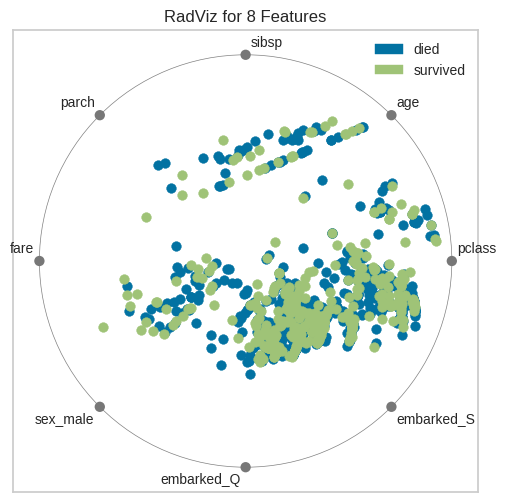

In [26]:
from yellowbrick.features import RadViz
fig, ax = plt.subplots(figsize=(6, 6))
rv = RadViz(
    classes=["died", "survived"],
    features=X.columns,
)

rv.fit(X, y)
_ = rv.transform(X)
rv.poof()
fig.savefig("images/mlpr_0612.png", dpi=300)

A biblioteca Pandas também gera gráficos RadViz

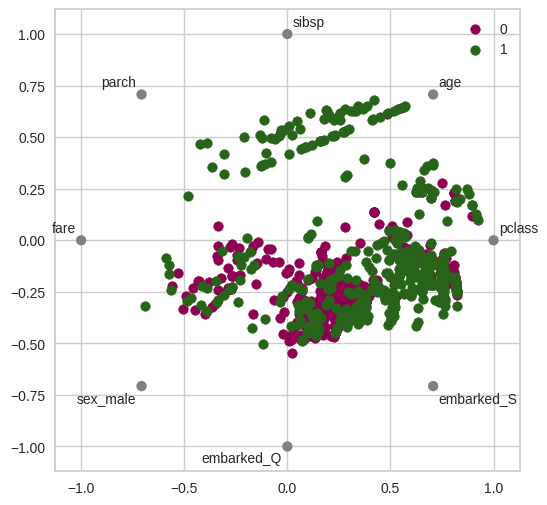

In [27]:
from pandas.plotting import radviz
fig, ax = plt.subplots(figsize=(6, 6))
new_df = X.copy()
new_df["target"] = y
radviz(
    new_df, "target", ax=ax, colormap="PiYG"
)
fig.savefig("images/mlpr_0613.png", dpi=300)

### Coordenadas paralelas

Para dados multivariados, podemos usar um gráfico de coordenadas paralelas para observar visualmente os agrupamentos

Mais uma vez, apresentamos uma versão com Yellowbrick:

/tmp/ipykernel_3216/2021296119.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


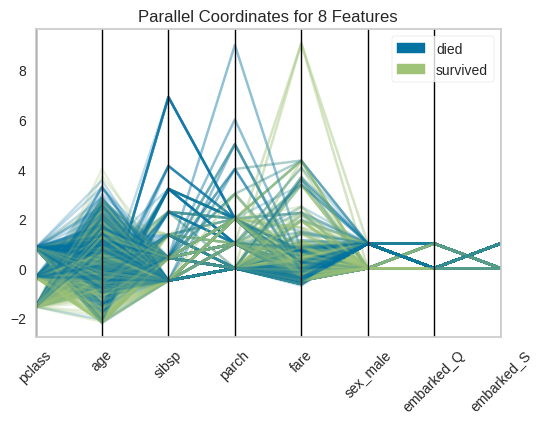

In [29]:
from yellowbrick.features import(
    ParallelCoordinates,
)
fig, ax = plt.subplots(figsize=(6, 4))
pc = ParallelCoordinates(
    classes=["died", "survived"],
    features=X.columns,
)
pc.fit(X, y)
pc.transform(X)
ax.set_xticklabels(
    ax.get_xticklabels(), rotation=45
)
pc.poof()
fig.savefig("images/mlpr_0614.png", dpi=300)

E uma versão com pandas

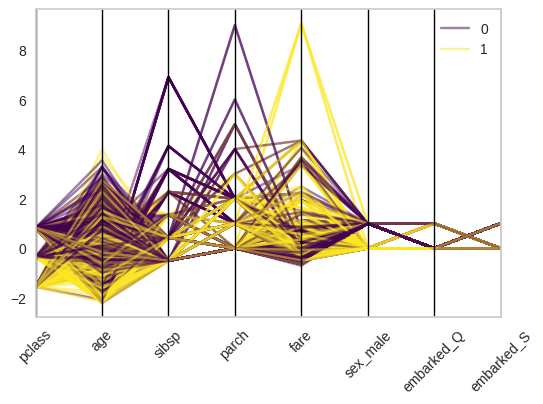

In [30]:
from pandas.plotting import(
    parallel_coordinates,
)
fig, ax=plt.subplots(figsize=(6, 4))
new_df = X.copy()
new_df["target"] = y
parallel_coordinates(
    new_df, 
    "target",
    ax=ax,
    colormap="viridis",
    alpha=0.5,
)
ax.set_xticklabels(
    ax.get_xticklabels(), rotation=45
)
fig.savefig("images/mlpr_0615.png",
           dpi=300,
           bbox_inches="tight")